In [1]:
import os
import subprocess
import xugrid as xu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx
#import 
%matplotlib inline

### Hurrywave

In [2]:
base_dir = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns'

model_dir = os.path.join(base_dir, 'NorthSeanobnd')

print(model_dir)

C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns\NorthSeanobnd


### Post-process Hurrywave results

In [3]:
### Post-process Hurrywave results
# Get the results from the netcdf file

nc_file = os.path.join(model_dir,'hurrywave_map.nc')
his_file = os.path.join(model_dir,'hurrywave_his.nc')

output_dir = os.path.join(model_dir, '1_postprocessing')
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

xu_nc = xu.open_dataset(nc_file , decode_times=True)

modig = {"msk": xu_nc["msk"],
         "zb": xu_nc["zb"],
         "Hm0": xu_nc["hm0"],
         #"Hm0_max": xu_nc["hm0max"],
         "Tp": xu_nc["tp"],
         "DIR": xu_nc["wavdir"],
         "ds": xu_nc["dirspr"],
         #"windspeed": xu_nc["windspeed"]
        }

# Assuming "time" is available in modig dictionary
time_variable =  xu_nc["time"]

xu_nc.close()

his = xu.open_dataset(his_file)
his = his.assign_coords({"stations": [x.decode("utf-8").strip() for x in his.station_name.values]})



In [4]:
# (OPTIONAL) Print available parameters in history-file
print(f"{'Variable Name':<15} {'Long Name':<65} {'Units':<15} {'Dimensions':<40}")
for var_name, data_array in his.variables.items():
    dimensions = str(data_array.dims)
    long_name = data_array.attrs.get('long_name', 'N/A')
    units = data_array.attrs.get('units', 'N/A')
    print(f"{var_name:<15}  {long_name:<65} {units:<15} {dimensions:<40}")

Variable Name   Long Name                                                         Units           Dimensions                              
inp              N/A                                                               N/A             ()                                      
station_id       N/A                                                               N/A             ('stations',)                           
station_name     N/A                                                               N/A             ('stations',)                           
station_x        original_x_coordinate_of_station                                  m               ('stations',)                           
station_y        original_y_coordinate_of_station                                  m               ('stations',)                           
station_z        bed_level_of_station                                              m               ('stations',)                           
crs              N/A 

In [5]:
from mpl_toolkits.basemap import Basemap

# Convert name to a list of strings
stations_list = [str(station_name.decode('utf-8')).split(' ')[0] for station_name in his['station_name'].values]
print(stations_list)

def get_station_index_from_name(stations_list, station_name):
    """
    Find the index of a station in the list of station names.
    """
    try:
        return stations_list.index(station_name)
    except ValueError:
        print(f"Station '{station_name}' not found in the list.")
        return None
    
def get_station_name_from_index(stations_list, station_index):
    """
    Get the station name for a specific station index.
    """
    if 0 <= station_index < len(stations_list):
        station_name = stations_list[station_index]
        return station_name
    else:
        print(f"Index {station_index} is out of range. Valid range is 0 to {len(stations_list) - 1}.")
        return None
    
def get_station_id(his, station_index):
    """
    Get the station ID for a specific station index.
    """
    station_id = his['station_id'].isel(stations=station_index).values
    return station_id

def get_time(his):
    """
    Get the timestamps from the history file.
    """
    time = his['time'].values
    return time

def get_time_seconds(his):
    time = get_time(his)
    time_seconds = (his['time'] - np.datetime64(time[0])).astype('timedelta64[s]').astype(int)
    return time_seconds

def get_average_dt(his):
    """
    Calculate the average time step (dt) from the history file.
    """
    time_seconds = get_time_seconds(his)
    dt = np.diff(time_seconds)  # Calculate the time differences
    return np.mean(dt)
    
def get_station_coordinates(his, station_index):
    """
    Get the coordinates of a specific station.
    """
    station_x = his['station_x'].isel(stations=station_index).values
    station_y = his['station_y'].isel(stations=station_index).values
    return station_x, station_y




['station_001', 'station_002', 'station_003', 'station_004', 'station_005', 'station_006', 'station_007', 'station_008', 'station_009']


In [6]:
# Load data for a specific station

def load_his_data(his, station_index):
    """
    Load data for a specific station from the history file.
    """
    # Extract all variables for the selected station
    variables = {}
    for var_name in his.variables:
        if 'stations' in his[var_name].dims:
            variables[var_name] = his[var_name].isel(stations=station_index).values
    return variables

def load_specific_variables(variables):
    """
    Load specific variables from the history file.
    """
    # Extract specific variables
    his_dt = get_average_dt(his)
    his_time = get_time(his)
    his_hm0 = variables.get('point_hm0', None)
    his_tp = variables.get('point_tp', None)
    his_wavdir = variables.get('point_wavdir', None)
    his_dirspr = variables.get('point_dirspr', None)
    his_wind_speed = variables.get('wind_speed', None)
    his_wind_direction = variables.get('wind_direction', None)


    return his_dt , his_time, his_hm0, his_tp, his_wavdir, his_dirspr, his_wind_speed, his_wind_direction

In [7]:
# Plotting function
def plot_his_data(his, station_indices, stations_list):
    """
    Plot the data for multiple stations and overlay their data on the same plots.
    Include a map showing the selected stations with labels.
    """

    fig = plt.figure(figsize=(12, 24))
    fig.suptitle('Hurrywave Model Results for Selected Stations', fontsize=16)

    # Add a map subplot at the top
    map_ax = fig.add_axes([0.1, 0.8, 0.8, 0.15])  # Adjusted position for the map
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65, llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Plot station locations on the map
    for station_index in station_indices:
        station_name = get_station_name_from_index(stations_list, station_index)
        station_x, station_y = get_station_coordinates(his, station_index)
        x, y = m(station_x, station_y)
        m.plot(x, y, 'ro', markersize=8)
        plt.text(x, y, f' {station_name}', fontsize=8, color='black')

    # Create subplots for the data below the map
    axs = fig.subplots(6, 1, gridspec_kw={'hspace': 0.5, 'top': 0.75})  # Adjusted top to fit below the map

    for station_index in station_indices:
        variables = load_his_data(his, station_index)
        his_dt, his_time, his_hm0, his_tp, his_wavdir, his_dirspr, his_wind_speed, his_wind_direction = load_specific_variables(variables)
        station_name = get_station_name_from_index(stations_list, station_index)

        # Plot Hm0
        axs[0].plot(his_time, his_hm0, label=f'{station_name}')
        axs[0].set_title('Hm0')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Hm0 (m)')
        axs[0].legend()

        # Plot Tp
        axs[1].plot(his_time, his_tp, label=f'{station_name}')
        axs[1].set_title('Tp')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Tp (s)')
        axs[1].legend()

        # Plot Wavdir
        axs[2].plot(his_time, his_wavdir, label=f'{station_name}')
        axs[2].set_title('Wavdir')
        axs[2].set_xlabel('Time')
        axs[2].set_ylabel('Wavdir (degrees)')
        axs[2].legend()

        # Plot Dirspr
        axs[3].plot(his_time, his_dirspr, label=f'{station_name}')
        axs[3].set_title('Dirsper')
        axs[3].set_xlabel('Time')
        axs[3].set_ylabel('Dirsper (degrees)')
        axs[3].legend()

        # Plot Wind Speed
        if his_wind_speed is not None:
            axs[4].plot(his_time, his_wind_speed, label=f'{station_name}')
            axs[4].set_title('Wind Speed')
            axs[4].set_xlabel('Time')
            axs[4].set_ylabel('Wind Speed (m/s)')
            axs[4].legend()

            # Plot Wind Direction
            if his_wind_direction is not None:
                axs[5].plot(his_time, his_wind_direction, label=f'{station_name}')
                axs[5].set_title('Wind Direction')
                axs[5].set_xlabel('Time')
                axs[5].set_ylabel('Wind Direction (degrees)')
                axs[5].legend()
        else:
            axs[4].axis('off')
            axs[5].axis('off')

    plt.show()


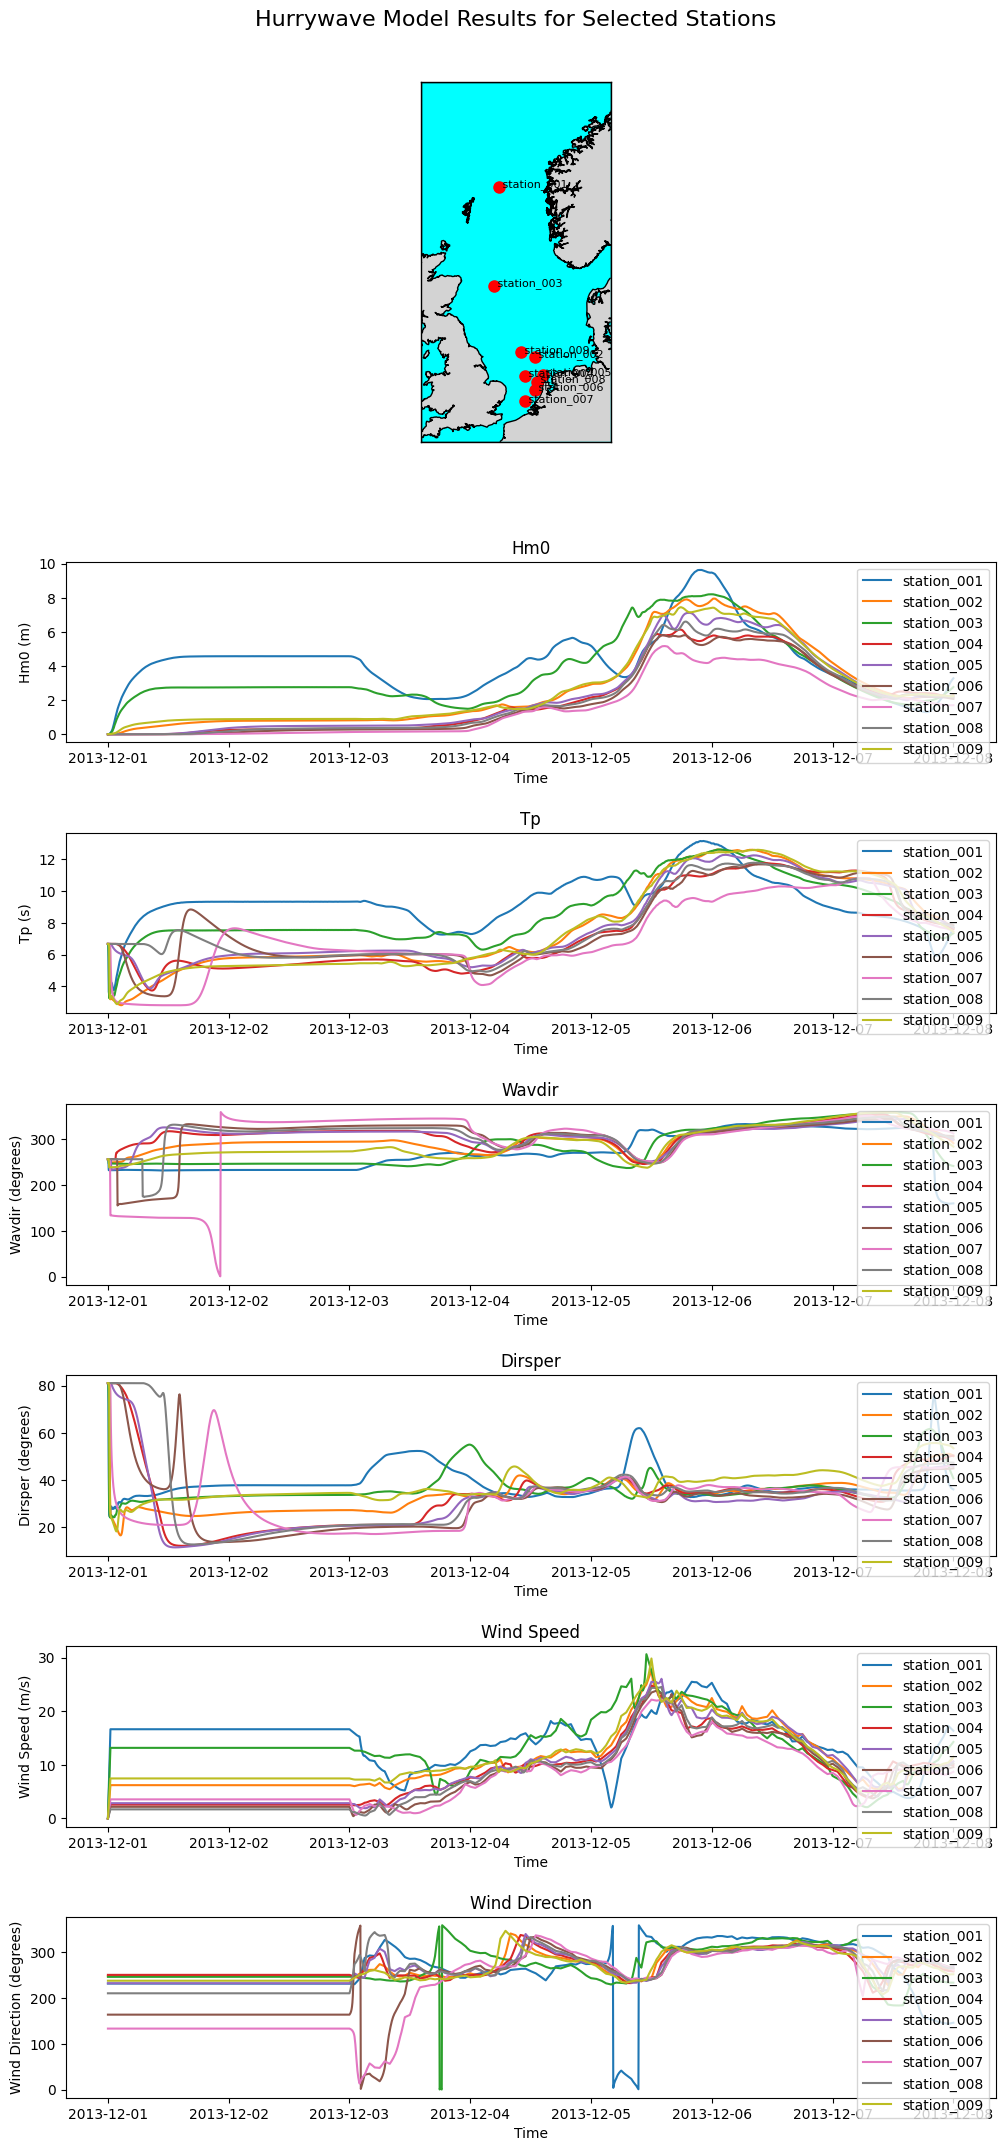

In [8]:
# Example usage
station_indices = list(range(len(stations_list)))  # List of station indices from 0 to len(stations_list) - 1
plot_his_data(his, station_indices, stations_list)

# ERA_5 Data


In [10]:
## LOAD ERA 5 DATA
data_dir = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\ERA5_data'
print(data_dir)

nc_file = os.path.join(data_dir,'mia_waves_2020_2024.nc')
data = xu.open_dataset(nc_file)


C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\ERA5_data


In [ ]:
# (OPTIONAL) Print available parameters in datatory-file
print(f"{'Variable Name':<15} {'Long Name':<65} {'Units':<15} {'Dimensions':<40}")
for var_name, data_array in data.variables.items():
    dimensions = str(data_array.dims)
    long_name = data_array.attrs.get('long_name', 'N/A')
    units = data_array.attrs.get('units', 'N/A')
    print(f"{var_name:<15}  {long_name:<65} {units:<15} {dimensions:<40}")

In [11]:
def load_station_data(data, lat_idx, lon_idx):
    """
    Load all relevant variables at a known station grid point (lat_idx, lon_idx).
    """
    variables = {}
    for var_name in data.data_vars:
        if ('valid_time' in data[var_name].dims and
            'latitude' in data[var_name].dims and
            'longitude' in data[var_name].dims):
            variables[var_name] = data[var_name][:, lat_idx, lon_idx].values
    return variables

def load_specific_variables(data, variables):
    """
    Extract and return selected wave-related variables from the grid point data.
    """
    data_dt = np.diff(data.valid_time.values).astype('timedelta64[s]').mean().astype(float)
    data_time = data.valid_time.values

    data_hm0 = variables.get('swh', None)             # Significant wave height
    data_tp = variables.get('pp1d', None)             # Peak period
    data_wavdir = variables.get('mwd', None)          # Mean wave direction
    data_dirspr = variables.get('wdw', None)          # Directional spread
    data_wind_speed = variables.get('shww', None)     # Wind wave height
    data_wind_direction = variables.get('mdww', None) # Wind wave direction

    return data_dt, data_time, data_hm0, data_tp, data_wavdir, data_dirspr, data_wind_speed, data_wind_direction

In [12]:
def get_number_of_latitude_values(data):
    """
    Get the number of latitude values in the dataset.
    """
    return len(data.latitude.values) if 'latitude' in data.dims else 0

def get_number_of_longitude_values(data):
    """
    Get the number of longitude values in the dataset.
    """
    return len(data.longitude.values) if 'longitude' in data.dims else 0

def get_latitude_values(data):
    """
    Get the latitude values from the dataset.
    """
    return data.latitude.values if 'latitude' in data.dims else None

def get_longitude_values(data):
    """
    Get the longitude values from the dataset.
    """
    return data.longitude.values if 'longitude' in data.dims else None

def get_lat_lon_values(data, lat_idx, lon_idx):
    """
    Get the latitude and longitude values for a specific grid point.
    """
    lat = data.latitude.values[lat_idx] if 'latitude' in data.dims else None
    lon = data.longitude.values[lon_idx] if 'longitude' in data.dims else None
    return lat, lon

def get_lat_lon_values_from_data(data):
    """
    Get the latitude and longitude values from the dataset.
    """
    lat = data.latitude.values if 'latitude' in data.dims else None
    lon = data.longitude.values if 'longitude' in data.dims else None
    return lat, lon

def get_closest_lat_idx_from_coords(data, lat):
    """
    Get the closest latitude index from the dataset for a given latitude coordinate.
    """
    lat_values = get_latitude_values(data)
    if lat_values is not None:
        return np.abs(lat_values - lat).argmin()
    return None

def get_closest_lon_idx_from_coords(data, lon):
    """
    Get the closest longitude index from the dataset for a given longitude coordinate.
    """
    lon_values = get_longitude_values(data)
    if lon_values is not None:
        return np.abs(lon_values - lon).argmin()
    return None

def get_closest_lat_lon_idx_from_coords(data, lat, lon):
    """
    Get the closest latitude and longitude indices from the dataset for given coordinates.
    """
    lat_idx = get_closest_lat_idx_from_coords(data, lat)
    lon_idx = get_closest_lon_idx_from_coords(data, lon)
    return lat_idx, lon_idx

def add_stations_to_dict(station_dict, data, lat_idx, lon_idx):
    """
    Add station metadata (name and coordinates) to the dictionary.
    """
    lat, lon = get_lat_lon_values(data, lat_idx, lon_idx)
    
    # Determine the station name
    if station_dict:
        last_station_name = max(station_dict.keys(), key=lambda k: int(k.replace('station', '')))
        station_number = int(last_station_name.replace('station', '')) + 1
    else:
        station_number = 1
    
    station_name = f'station{station_number:03d}'
    
    # Add station metadata to the dictionary
    station_dict[station_name] = (lat, lon)
    return station_dict

def add_stations_to_dict_from_data(station_dict, data):
    """
    Add all stations to the dictionary using the dataset.
    """
    for lat_idx in range(get_number_of_latitude_values(data)):
        for lon_idx in range(get_number_of_longitude_values(data)):
            station_dict = add_stations_to_dict(station_dict, data, lat_idx, lon_idx)
    return station_dict


def add_stations_to_dict_from_coords(station_dict, data, lat, lon):
    """
    Add station data to the dictionary using latitude and longitude coordinates.
    """
    lat_idx, lon_idx = get_closest_lat_lon_idx_from_coords(data, lat, lon)
    return add_stations_to_dict(station_dict, data, lat_idx, lon_idx)

def add_stations_to_dict_from_coordata_list(station_dict, data, coordata_list):
    """
    Add multiple stations to the dictionary using a list of latitude and longitude coordinates.
    """
    for lat, lon in coordata_list:
        station_dict = add_stations_to_dict_from_coords(station_dict, data, lat, lon)
    return station_dict

def create_station_dict(data):
    """
    Create a dictionary of stations with their latitude and longitude as keys.
    """
    station_dict = {}
    station_dict = add_stations_to_dict_from_data(station_dict, data)
    return station_dict

def print_station_dict(station_dict):
    """
    Print the station dictionary.
    """
    print(f"Number of stations in the dictionary: {len(station_dict)}")
    for station_name, (lat, lon) in station_dict.items():
        print(f"{station_name}: Latitude: {lat}, Longitude: {lon}")

In [13]:
station_dict = create_station_dict(data)

print_station_dict(station_dict)

Number of stations in the dictionary: 4
station001: Latitude: 51.9, Longitude: 3.0
station002: Latitude: 51.9, Longitude: 3.5
station003: Latitude: 51.9, Longitude: 4.0
station004: Latitude: 51.9, Longitude: 4.5


In [14]:
# Plotting function
def plot_data(data, station_dict, show_labels=True):
    """
    Plot time series and map for multiple stations using lat/lon from station_dict.

    Parameters:
        data: xarray.Dataset
        station_dict: dict of {"station_name": (lat, lon)}
        show_labels: bool, optional
            If True, display labels next to station markers on the map. Default is True.
    """
    fig = plt.figure(figsize=(12, 24))
    fig.suptitle('Wave Model Results for Selected Stations', fontsize=16)

    # Add a map subplot at the top
    map_ax = fig.add_axes([0.1, 0.8, 0.8, 0.15])
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    # Create subplots
    axs = fig.subplots(6, 1, gridspec_kw={'hspace': 0.5, 'top': 0.75})

    for station_name, (lat, lon) in station_dict.items():
        # Find nearest grid point index
        lat_idx, lon_idx = get_closest_lat_lon_idx_from_coords(data, lat, lon)

        # Get data
        variables = load_station_data(data, lat_idx, lon_idx)
        data_dt, data_time, data_hm0, data_tp, data_wavdir, data_dirspr, data_wind_speed, data_wind_direction = \
            load_specific_variables(data, variables)

        # Plot location on map
        x, y = m(lon, lat)
        m.plot(x, y, 'ro', markersize=8)
        if show_labels:
            map_ax.text(x, y, f' {station_name}', fontsize=8, color='black')

        # Plot time series
        axs[0].plot(data_time, data_hm0, label=f'{station_name}')
        axs[1].plot(data_time, data_tp, label=f'{station_name}')
        axs[2].plot(data_time, data_wavdir, label=f'{station_name}')
        axs[3].plot(data_time, data_dirspr, label=f'{station_name}')

        if data_wind_speed is not None:
            axs[4].plot(data_time, data_wind_speed, label=f'{station_name}')
        if data_wind_direction is not None:
            axs[5].plot(data_time, data_wind_direction, label=f'{station_name}')

    # Titles and labels
    titles = ['Hm0', 'Tp', 'Wave Direction', 'Directional Spread', 'Wind Speed', 'Wind Direction']
    ylabels = ['Hm0 (m)', 'Tp (s)', 'Direction (°)', 'Spread (rad)', 'Speed (m/s)', 'Direction (°)']
    for ax, title, ylabel in zip(axs, titles, ylabels):
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel(ylabel)
        ax.legend()

    plt.show()

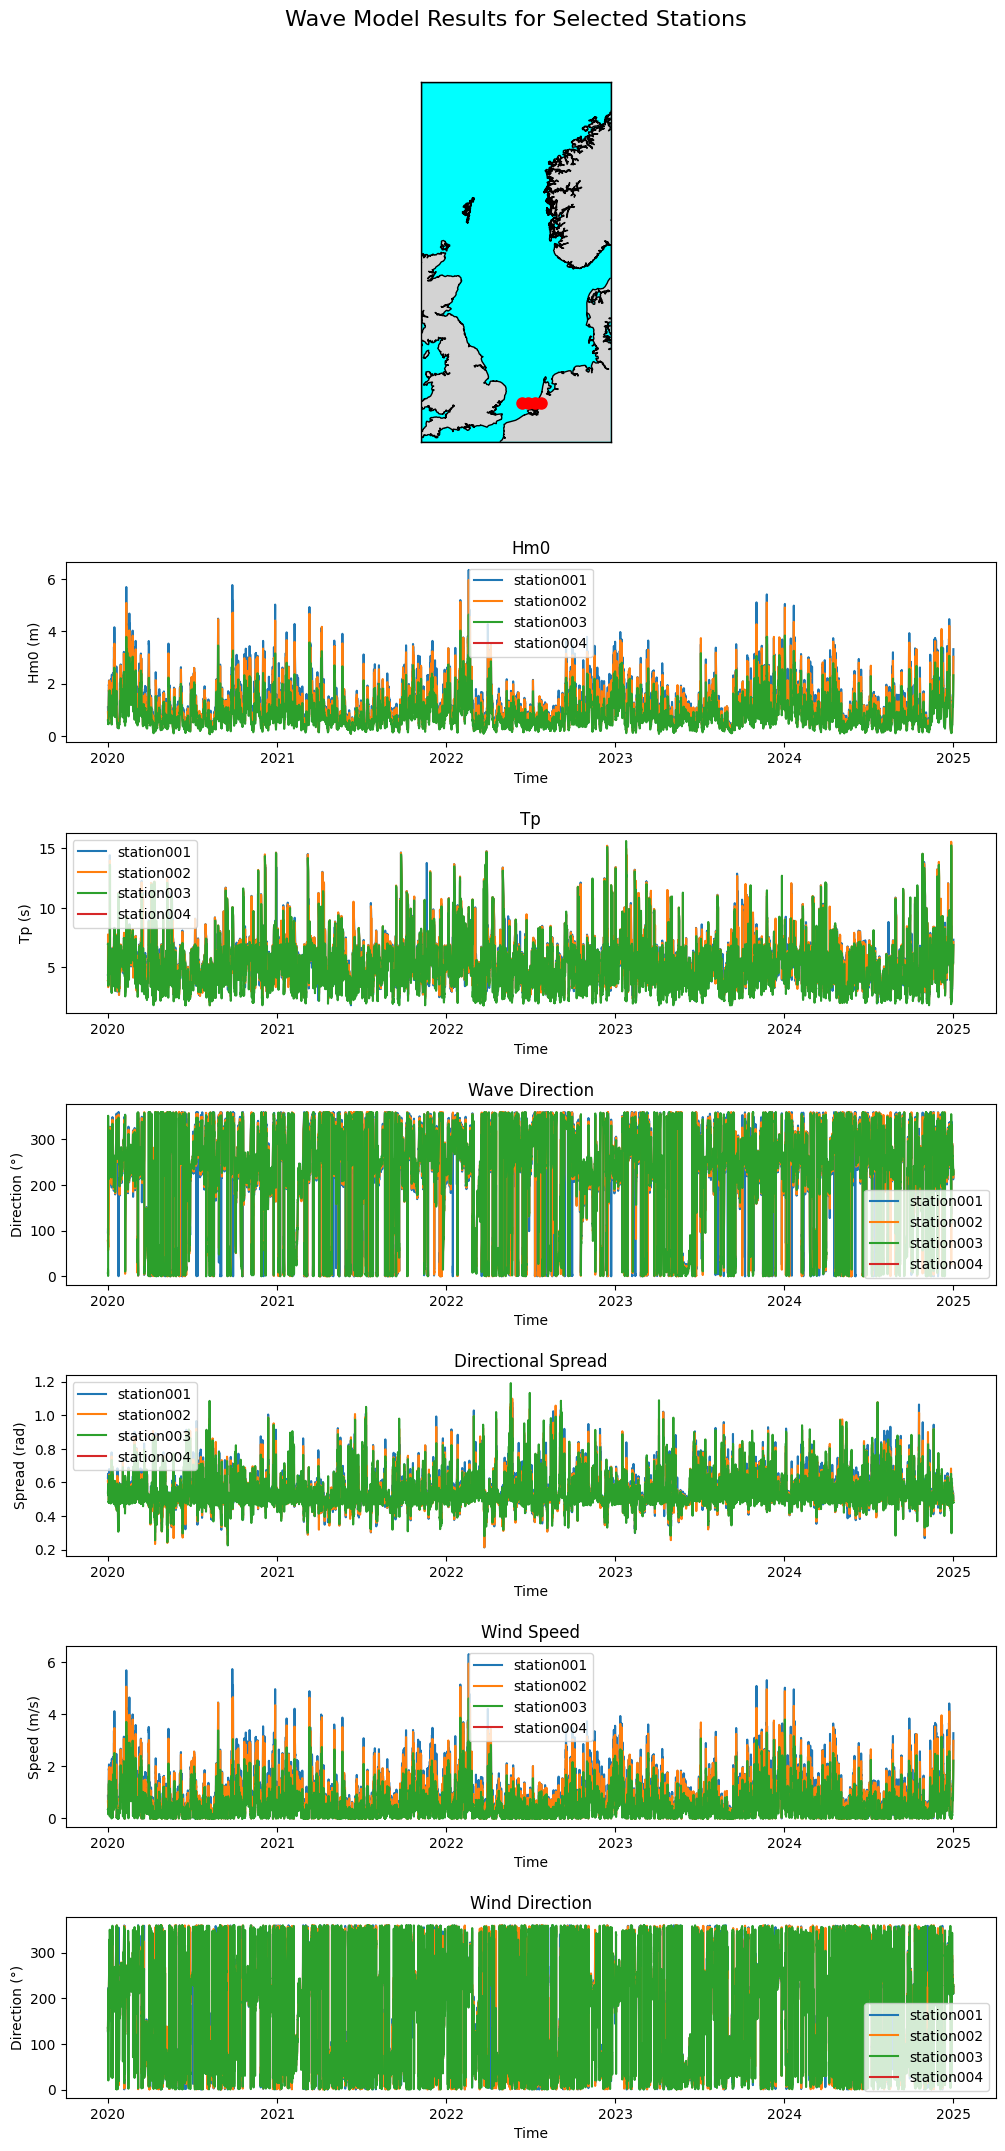

In [15]:
plot_data(data, station_dict, show_labels=False)

# MAPS

In [72]:
bnd_path = os.path.join(model_dir, 'hurrywave.bnd')
bnd = pd.read_csv(bnd_path, header=0, sep=' ', names=['x', 'y'])
bnd = np.array(bnd)

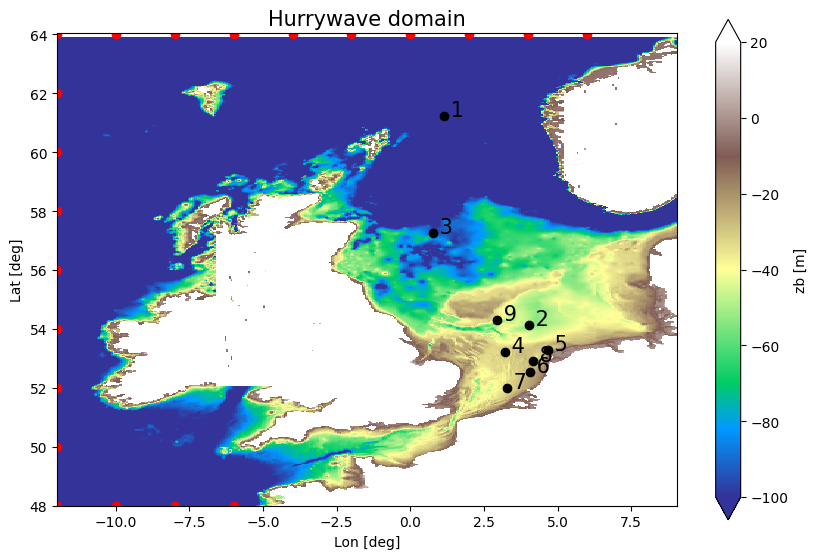

In [75]:
# plot bed level - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['zb'].plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "terrain",
                 vmin = -100, vmax = 20,
                 cbar_kwargs={'label': 'zb [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'bathy3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

We can plot other variables on this map, such as the maximum significant waveheight (Hm0_max)

Animation of the hurricane track (Check your output folder for the results!)

In [67]:
modig["Hm0"]

<xarray.DataArray 'hm0' (time: 337, n: 481, m: 421)> Size: 273MB
[68242837 values with dtype=float32]
Coordinates:
    x        (n, m) float32 810kB ...
    y        (n, m) float32 810kB ...
  * time     (time) datetime64[ns] 3kB 2013-12-01 ... 2013-12-08
Dimensions without coordinates: n, m
Attributes:
    units:          m
    standard_name:  sea_surface_wave_significant_height
    long_name:      Significant wave height Hm0 (m)

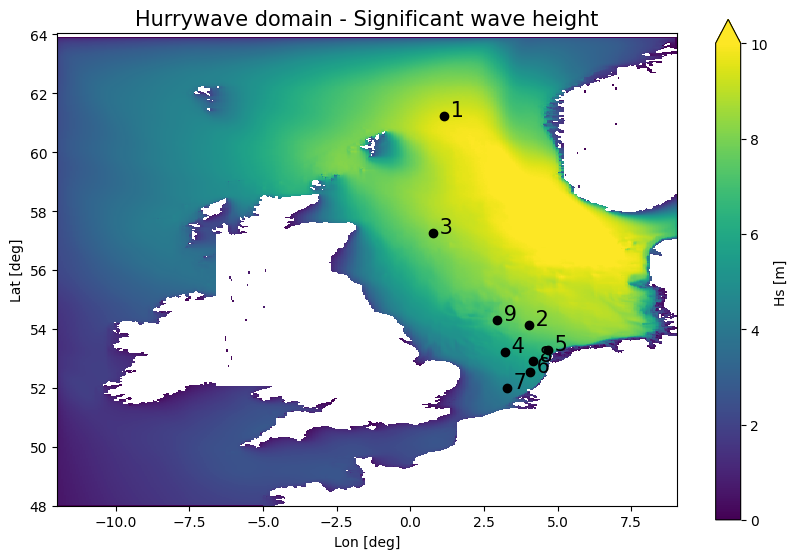

In [76]:
# plot wave height - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Hm0'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 0, vmax = 10,
                 cbar_kwargs={'label': 'Hs [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Significant wave height', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]') 

#plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveheight3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

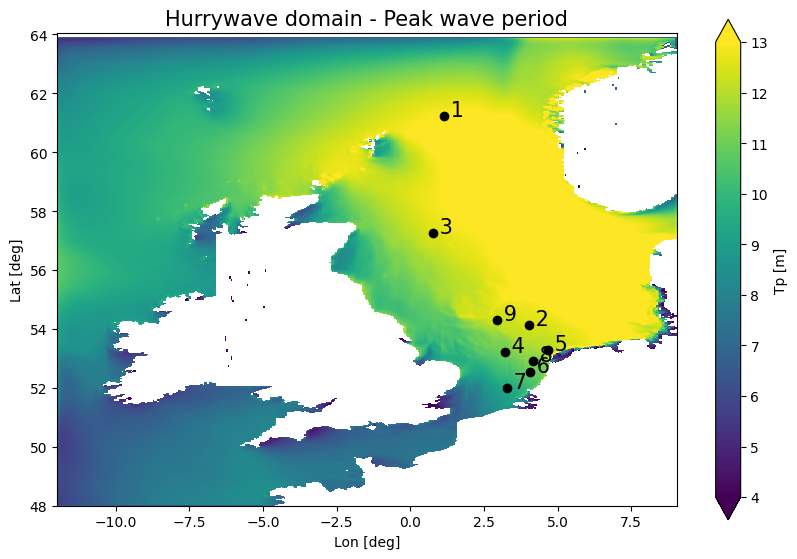

In [77]:
# plot wave period - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Tp'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 4, vmax = 13,
                 cbar_kwargs={'label': 'Tp [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Peak wave period', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveperiod3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

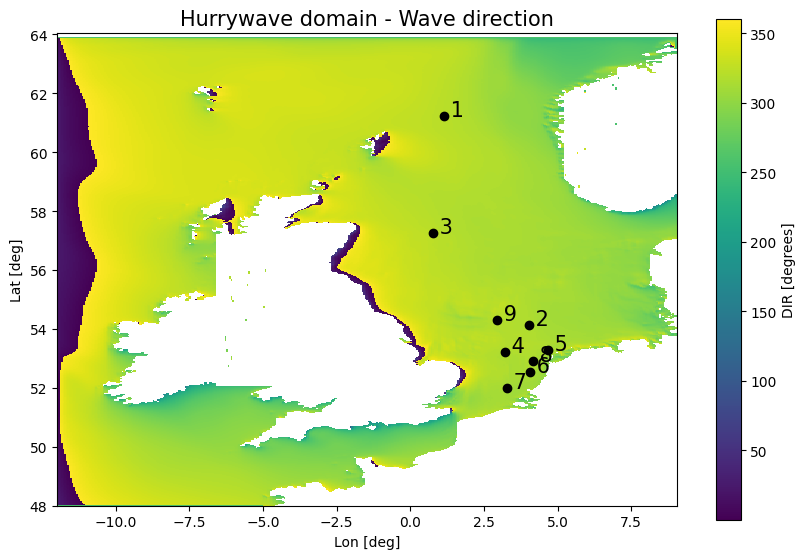

In [78]:
# plot wave direction - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['DIR'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 cbar_kwargs={'label': 'DIR [degrees]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Wave direction', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'direction3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

In [79]:
modig

{'msk': <xarray.DataArray 'msk' (n: 481, m: 421)> Size: 810kB
 [202501 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
 Dimensions without coordinates: n, m
 Attributes:
     units:          -
     standard_name:  land_binary_mask
     long_name:      msk_active_cells
     description:    inactive=0, active=1, boundary=2,
 'zb': <xarray.DataArray 'zb' (n: 481, m: 421)> Size: 810kB
 [202501 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
 Dimensions without coordinates: n, m
 Attributes:
     units:          m
     standard_name:  altitude
     long_name:      bed_level_above_reference_level,
 'Hm0': <xarray.DataArray 'hm0' (time: 337, n: 481, m: 421)> Size: 273MB
 [68242837 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
   * time     (time) datetime64[ns] 3kB 2013-12-01 ... 2